## Clean text

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc; gc.enable()

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os

# Any results you write to the current directory are saved as output.

text_cols = ['param_1', 'param_2', 'param_3', 'title', 'description']
train = pd.read_csv('data/train.csv', parse_dates=['activation_date'], usecols=text_cols+['activation_date']) \
          .sort_values('activation_date') \
          .reset_index(drop=True)
test = pd.read_csv('data/test.csv', parse_dates=['activation_date'],  usecols=text_cols+['activation_date'])

all_df = pd.concat([train,test]).reset_index(drop=True)
del train, test; gc.collect()

all_df.loc[:, text_cols] = all_df[text_cols].fillna('khyehwinkaggle')

title_feature = all_df['title']
param_feature = all_df['param_1'] + ' ' + all_df['param_2'] + ' ' + all_df['param_3']
text_feature =  all_df['description']
                
del all_df; gc.collect()
print('merge done')    
                
from nltk.corpus import stopwords                
from nltk.stem.snowball import RussianStemmer
stemmer = RussianStemmer(ignore_stopwords=False)
def clean_text(txt):
    words = str(txt).lower().strip().split(" \t\r.,!?^+-*/@~:;/\\\"\'&{}[]()#$%") #str(txt).split(" ") #
    words = [stemmer.stem(wrd) for wrd in words \
                if wrd not in stopwords.words('russian') and len(wrd) > 1]
    txt = u" ".join(words)
    return txt
all_texts = text_feature.apply(clean_text); print('description clean text done')  

import pickle
with open('title_text_feature.pickle', 'wb') as handle:
    pickle.dump(title_feature, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print('title text features saved')

with open('param_text_feature.pickle', 'wb') as handle:
    pickle.dump(param_feature, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print('param text features saved')
    
with open('desc_text_feature.pickle', 'wb') as handle:
    pickle.dump(all_texts, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print('desc text features saved')

merge done
description clean text done
title text features saved
param text features saved
desc text features saved


## Generate count vec for title & params

In [1]:
import pandas as pd
import numpy as np
import gc; gc.enable()
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
import pickle
from scipy.sparse import csr_matrix

In [2]:
with open('title_text_feature.pickle', 'rb') as handle:
    title_feature = pickle.load(handle)
    print('title text features loaded')
    
count_vectorizer_title = CountVectorizer(stop_words=stopwords.words('russian'), lowercase=True, min_df=25)
title_feature = count_vectorizer_title.fit_transform(title_feature); print('title cv transformed')

with open('title_text_feature_count_vec.pickle', 'wb') as handle:
    pickle.dump(title_feature, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print('title text features saved')

title text features loaded
title cv transformed
title text features saved


In [3]:
title_feature.shape

(2011862, 16447)

In [7]:
del title_feature
with open('param_text_feature.pickle', 'rb') as handle:
    param_feature = pickle.load(handle)
    print('param text features loaded')
    
count_vectorizer_param = CountVectorizer(stop_words=stopwords.words('russian'), lowercase=True, min_df=10)
param_feature = count_vectorizer_param.fit_transform(param_feature); print('param cv transformed')

with open('param_text_feature_count_vec.pickle', 'wb') as handle:
    pickle.dump(param_feature, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print('param text features saved')

param text features loaded
param cv transformed
title text features saved


In [8]:
param_feature.shape

(2011862, 1390)

In [ ]:
del param_feature

## Generate TF-IDF + 1-gram BOW + 2-gram BOW for descriptions

In [2]:
import pandas as pd
import numpy as np
import gc; gc.enable()
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
import pickle
from scipy.sparse import csr_matrix

In [3]:
with open('desc_text_feature.pickle', 'rb') as handle:
    all_texts = pickle.load(handle)
    print('desc text features loaded')

desc text features loaded


In [4]:
desc_tf_idf_features = TfidfVectorizer(ngram_range=(1, 2),
                                       lowercase=True,
                                       analyzer='word',
                                       smooth_idf=False,
                                       sublinear_tf=True,
                                       max_features=20000,
                                       max_df=0.9, stop_words=stopwords.words('russian'),
                                       norm='l2').fit_transform(all_texts)
print('TFIDF transformation done.')
with open('desc_text_feature_tf_vec.pickle', 'wb') as handle:
    pickle.dump(desc_tf_idf_features, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print(desc_tf_idf_features.shape)
    print('desc text features saved')
    del desc_tf_idf_features; gc.collect()

TFIDF transformation done.
(2011862, 20000)
desc text features saved


In [ ]:
desc_count_vec_features = CountVectorizer(ngram_range =(1,1), lowercase=True,
                                          max_features=20000, max_df=0.9).fit_transform(all_texts)

with open('desc_text_feature_count_vec_1gram.pickle', 'wb') as handle:
    pickle.dump(csr_matrix(desc_count_vec_features), handle, protocol=pickle.HIGHEST_PROTOCOL)
    print('desc text features saved')
    del desc_count_vec_features; gc.collect()

In [6]:
desc_count_vec_features = CountVectorizer(ngram_range =(2,2), lowercase=True,
                                          max_features=20000, max_df=0.9).fit_transform(all_texts)

with open('desc_text_feature_count_vec_2gram.pickle', 'wb') as handle:
    pickle.dump(csr_matrix(desc_count_vec_features), handle, protocol=pickle.HIGHEST_PROTOCOL)
    print('desc text features saved')
    del desc_count_vec_features; gc.collect()

desc text features saved


## Merge + PCA

In [2]:
import pandas as pd
import numpy as np
import gc; gc.enable()
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
import pickle
from scipy.sparse import csr_matrix, hstack
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
merge_files = [
    'title_text_feature_count_vec.pickle',
    'param_text_feature_count_vec.pickle',
    'desc_text_feature_tf_vec.pickle',
    'desc_text_feature_count_vec_1gram.pickle',
    'desc_text_feature_count_vec_2gram.pickle'
]

In [3]:
all_text = hstack([pickle.load(open(f, 'rb')) for f in merge_files]).tocsr()

In [4]:
all_text.shape

(2011862, 77837)

In [5]:
with open('all_text_fusion.pickle', 'wb') as handle:
    pickle.dump(all_text, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print('desc text features saved')

desc text features saved


In [6]:
from sklearn.decomposition import TruncatedSVD

In [7]:
svd_raw = TruncatedSVD(n_components=500).fit(all_text)

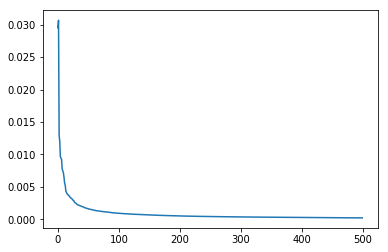

In [8]:
pd.Series(svd_raw.explained_variance_ratio_).plot()
plt.show()

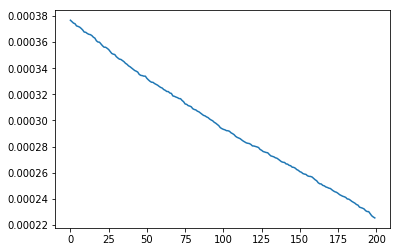

In [13]:
pd.Series(svd_raw.explained_variance_ratio_[300:]).plot()
plt.show()

> Feature num=300 is good enough by the explained var ratio.

In [14]:
all_text_svd = TruncatedSVD(n_components=300).fit_transform(all_text)

In [15]:
train_len = pd.read_csv('data/train.csv', usecols=['deal_probability']).shape[0]

In [16]:
with open('train_text_svd.pickle', 'wb') as handle:
    pickle.dump(all_text_svd[:train_len,:], handle, protocol=pickle.HIGHEST_PROTOCOL)
    print('desc text features saved')

desc text features saved


In [17]:
with open('test_text_svd.pickle', 'wb') as handle:
    pickle.dump(all_text_svd[train_len:,:], handle, protocol=pickle.HIGHEST_PROTOCOL)
    print('desc text features saved')

desc text features saved
